In [92]:
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import matplotlib.pyplot as plt

In [93]:
data1 = [35492, 45298, 46087, 36707, 52290, 66464, 77187, 64262, 70727, 118820, 131687, 135180]

In [94]:
data2 = [38199, 41711, 41785, 38269, 47993, 59617, 70611, 60436, 84133, 129021, 142913, 140987]

In [95]:
data3 = [605, 772, 849, 1075, 1237, 1386, 1597, 1610, 1826, 2471, 3145, 3552]

In [96]:
data4 = [2325, 2654, 2376, 1843, 1924, 2662, 4430, 1895, 1193, 2001, 2674, 1688]

In [97]:
data5 = [257, 210, 280, 455, 401, 730, 1044, 1499, 1241, 1749, 1927, 2462]

In [98]:
for i in range(1,6):
    print(rate_net_profit_growth(eval(f'data{i}')))

5.17
5.08
8.03
0.0
8.0


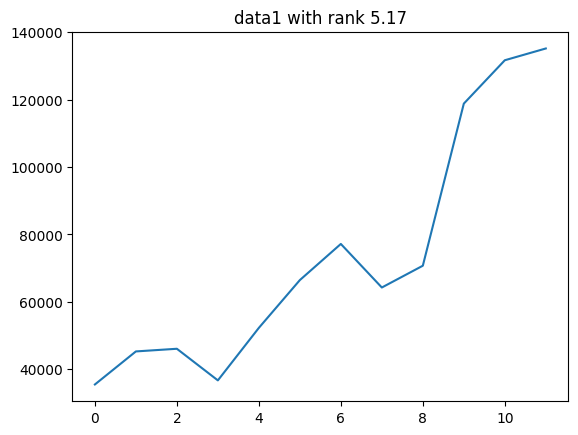

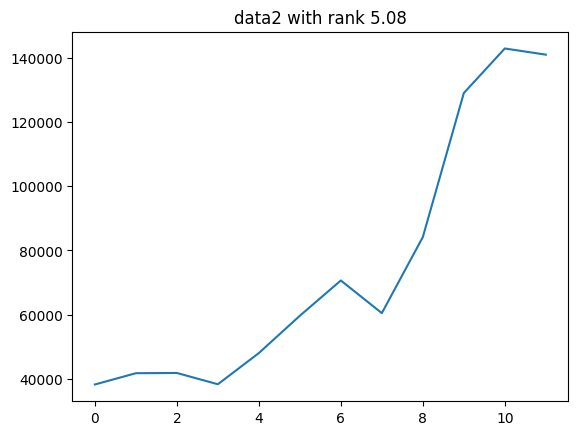

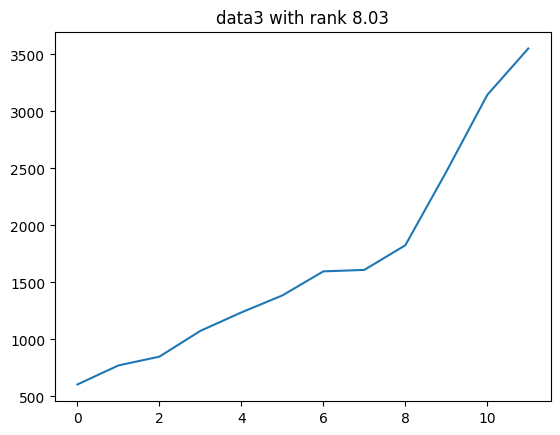

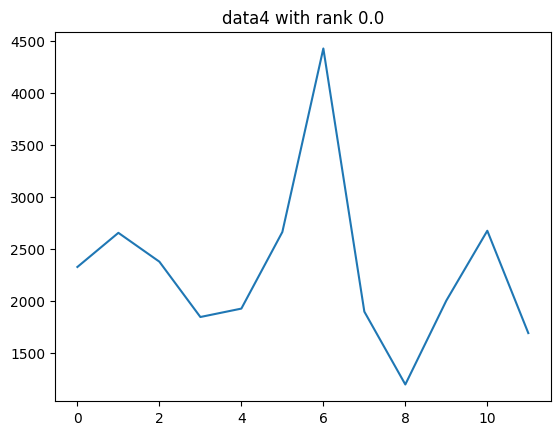

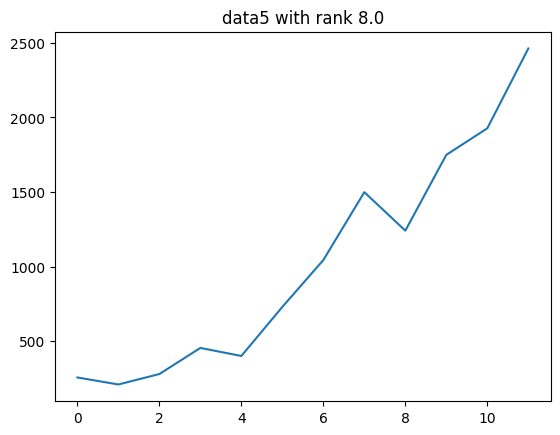

In [99]:
for i in range(1,6):
    plt.title(f'data{i} with rank {rate_net_profit_growth(eval(f"data{i}"))}')
    plt.plot(eval(f'data{i}'))
    plt.show()

In [100]:
ideal_data = [(1.2)**i for i in range(12)]

In [101]:
# Normalize the data

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

data_normalized = normalize(np.array(data))
ideal_data_normalized = normalize(np.array(ideal_data))


DTW Distance: 3.988055877747549


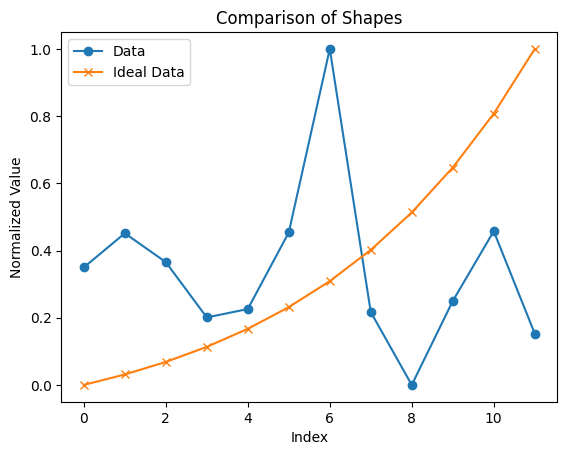

In [102]:
# Reshape data to 2-D arrays
data_normalized_2d = data_normalized.reshape(-1, 1)
ideal_data_normalized_2d = ideal_data_normalized.reshape(-1, 1)

# Calculate DTW distance
distance, path = fastdtw(data_normalized_2d, ideal_data_normalized_2d, dist=euclidean)

print(f"DTW Distance: {distance}")

# Plot the normalized data
plt.plot(data_normalized, label='Data', marker='o')
plt.plot(ideal_data_normalized, label='Ideal Data', marker='x')
plt.xlabel('Index')
plt.ylabel('Normalized Value')
plt.title('Comparison of Shapes')
plt.legend()
plt.show()

In [103]:
correlation = np.corrcoef(data_normalized, ideal_data_normalized)[0, 1]

In [104]:
# For a simple approach, use the Euclidean distance between points
from scipy.spatial.distance import cdist

def shape_similarity(data1, data2):
    distances = cdist(np.array(data1).reshape(-1, 1), np.array(data2).reshape(-1, 1), metric='euclidean')
    return np.mean(np.min(distances, axis=0)) + np.mean(np.min(distances, axis=1))

similarity = shape_similarity(data_normalized, ideal_data_normalized)


In [105]:
similarity

0.0826038393618903

In [106]:
def dtw_rating(distance, max_distance):
    return max(0, 10 - (distance / max_distance * 10))

# Assume max_distance is a known or predefined value
max_dtw_distance = 1.0  # Example value
dtw_rating_value = dtw_rating(distance, max_dtw_distance)


In [107]:
correlation_rating = (correlation + 1) / 2 * 10 # Maps -1 to 1 range to 0 to 10 scale

correlation_rating_rounded = round(correlation_rating)



In [108]:
correlation_rating_rounded

4

In [109]:
import numpy as np

def calculate_cagr(net_profits):
    initial_value = net_profits[0]
    final_value = net_profits[-1]
    n = len(net_profits) - 1  # number of intervals
    if initial_value == 0:  # Avoid division by zero
        return -1  # Return an invalid CAGR to indicate an error
    cagr = (final_value / initial_value) ** (1 / n) - 1
    return cagr

def calculate_yoy_growth(net_profits):
    yoy_growth = []
    for i in range(1, len(net_profits)):
        growth = (net_profits[i] - net_profits[i - 1]) / net_profits[i - 1]
        yoy_growth.append(growth)
    return yoy_growth

def calculate_volatility(yoy_growth):
    return np.std(yoy_growth)  # Standard deviation of YoY growth rates

def rate_net_profit_growth(net_profits, growth_weight=0.8, consistency_weight=0.2):
    # Calculate CAGR-based score
    cagr = calculate_cagr(net_profits)
    if cagr < 0:
        cagr_score = 0  # If there's negative growth, score 0
    elif cagr >= 0.2:
        cagr_score = 10  # If CAGR is 20% or more, score 10
    else:
        cagr_score = round((cagr / 0.2) * 10, 2)  # Scale score linearly for CAGR < 20%

    # Calculate YoY growth rates and consistency score
    yoy_growth = calculate_yoy_growth(net_profits)
    volatility = calculate_volatility(yoy_growth)

    # Scale consistency score (lower volatility = higher consistency score)
    # For simplicity, we can say if volatility > 0.2, score 0; if volatility is 0, score 10
    consistency_score = max(0, 10 - (volatility * 50))  # Adjust scaling factor as necessary

    # Combine the growth and consistency scores
    final_score = round((growth_weight * cagr_score) + (consistency_weight * consistency_score), 2)
    return final_score

# Example usage:
score = rate_net_profit_growth(data1)
print("Rating out of 10:", score)


Rating out of 10: 5.17


In [ ]:
def rate_net_interest_revenue(data, anchor, growth_positive=True, weight_anchor=0.5, weight_growth=0.5):
    # Step 1: Calculate the average nearness to the anchor
    deviations = [abs(value - anchor) for value in data]
    avg_deviation = sum(deviations) / len(deviations)
    
    # Scale the anchor score: The smaller the deviation, the higher the score
    # Assuming 10 is the perfect score for being close to the anchor, we scale accordingly
    anchor_score = max(0, 10 - (avg_deviation / anchor * 10))  # Adjust scaling factor as necessary
    
    # Step 2: Calculate the growth trend and final difference
    initial_value = data[0]
    final_value = data[-1]
    final_difference = final_value - initial_value
    
    # Determine the growth trend score
    if (final_difference > 0 and growth_positive) or (final_difference < 0 and not growth_positive):
        growth_score = min(10, abs(final_difference / initial_value * 10))  # Scale based on relative growth
    else:
        growth_score = max(0, 10 - abs(final_difference / initial_value * 10))  # Penalize for undesired direction

    # Step 3: Combine the scores with respective weights
    final_score = round((weight_anchor * anchor_score) + (weight_growth * growth_score), 2)
    return final_score

# Example usage:
data = [8, 9, 10, 10.5, 11, 12, 12.5, 13]  # Example data for Net Interest by Revenue
anchor = 10  # Target value we want the graph to stay near
growth_positive = True  # We prefer an increasing trend
weight_anchor = 0.6  # 60% weight to anchor proximity
weight_growth = 0.4  # 40% weight to growth

score = rate_net_interest_revenue(data, anchor, growth_positive, weight_anchor, weight_growth)
print("Rating out of 10:", score)
